<a href="https://colab.research.google.com/github/cnorton27/Garibaldi-vegetation-mapping-model/blob/main/RandomForest_Supervised_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installing dependencies

In [ ]:
%%shell
yes | add-apt-repository ppa:ubuntugis/ppa
apt-get update
apt-get install gdal-bin libgdal-dev
C_INCLUDE_PATH=/usr/include/gdal CPLUS_INCLUDE_PATH=/usr/include/gdal python -m pip install GDAL=="$(gdal-config --version)"



PPA publishes dbgsym, you may need to include 'main/debug' component
Repository: 'deb https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu/ jammy main'
Description:
Official stable UbuntuGIS packages.


More info: https://launchpad.net/~ubuntugis/+archive/ubuntu/ppa
Adding repository.
Found existing deb entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding deb entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Found existing deb-src entry in /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding disabled deb-src entry to /etc/apt/sources.list.d/ubuntugis-ubuntu-ppa-jammy.list
Adding key to /etc/apt/trusted.gpg.d/ubuntugis-ubuntu-ppa.gpg with fingerprint 6B827C12C2D425E227EDCA75089EBE08314DF160
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,58

In [ ]:
!apt-get install -y python3-gdal

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-gdal is already the newest version (3.6.4+dfsg-1~jammy0).
python3-gdal set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.


In [ ]:
pip install rasterio scikit-learn-intelex caret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.2/63.2 MB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 9.5 MB/s eta 0:00:00


In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()
import rasterio as rio
import numpy as np
import geopandas as pd
from sklearn.model_selection import train_test_split
import fiona
from rasterio.features import geometry_mask
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from rasterio.plot import show
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from osgeo import ogr, gdal
from glob import glob
import rasterio.warp
from rasterio.enums import Resampling
import subprocess

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Preparing the raster data for model input

In [ ]:
# input files
satellite2 = '/content/drive/MyDrive/PIXELS_python/Data/sat_clip.tif'
dem_path = "/content/drive/MyDrive/PIXELS_python/Data/DEM_clip_bilinear.tif" #dem from gov website 25m
split_train = "/content/drive/MyDrive/PIXELS_python/subnumclass/subnumclass_points_train.shp" #bottom up subnumclass
split_test = "/content/drive/MyDrive/PIXELS_python/subnumclass/subnumclass_points_test.shp" #bottom up subnumclass
#split_train = "/content/drive/MyDrive/PIXELS_python/training_points_top_down/test_attributed_top_down.shp" #top_down
#split_test = "/content/drive/MyDrive/PIXELS_python/training_points_top_down/trainingg_attributed_top_down.shp" #top_down
NDVI_path = "/content/drive/MyDrive/PIXELS_python/Data/new_ndvi.tif"
shadow_path = '/content/drive/MyDrive/PIXELS_python/Data/shade12pmcrop.tif'


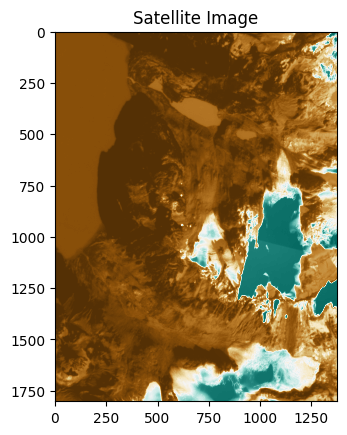

Satellite Coordinate Reference System
EPSG:32610
DEM Coordinate Reference System
EPSG:32610


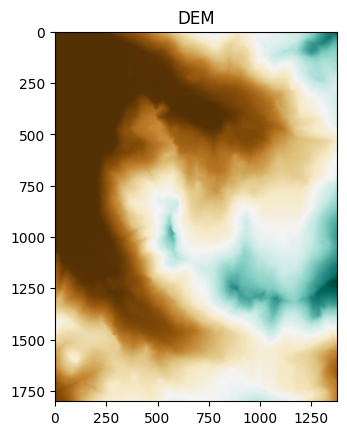

In [ ]:
#Get CRS for both DEM and Sat

sat = rasterio.open(satellite2)
DEM = rasterio.open(dem_path)
DEM_src = DEM.read(1)
band2 = sat.read(2)
plt.imshow(band2, cmap = "BrBG")
plt.title("Satellite Image")
plt.show()

print("Satellite Coordinate Reference System")
sat_crs = sat.crs
print(sat_crs)

print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

plt.imshow(DEM_src, cmap = "BrBG")
plt.title("DEM")
plt.show()

In [ ]:
#reproject layers to match CRS of satellite imagery (or other crs)

def reproject_raster(in_path, out_path, target_crs):
    with rio.open(in_path) as src:
        transform, width, height = rio.warp.calculate_default_transform(src.crs, target_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': target_crs,
            'transform': transform,
            'width': width,
            'height': height
        })

        with rio.open(out_path, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                rio.warp.reproject(
                    source=rio.band(src, i),
                    destination=rio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=target_crs,
                    resampling=Resampling.nearest
                )

# assign target crs to variable, define output directory for reprojected layers
target_crs = 'EPSG:32610'
output_dem = "/content/drive/MyDrive/PIXELS_python/Data/reprojected_DEM.tif"

# Reproject the slope, tpi, and any other rasters used as model input
reproject_raster(dem_path, output_dem, target_crs)

#reassign variables
dem_path = output_dem

DEM = rasterio.open(dem_path)
print("DEM Coordinate Reference System")
dem_crs = DEM.crs
print(dem_crs)

DEM Coordinate Reference System
EPSG:32610


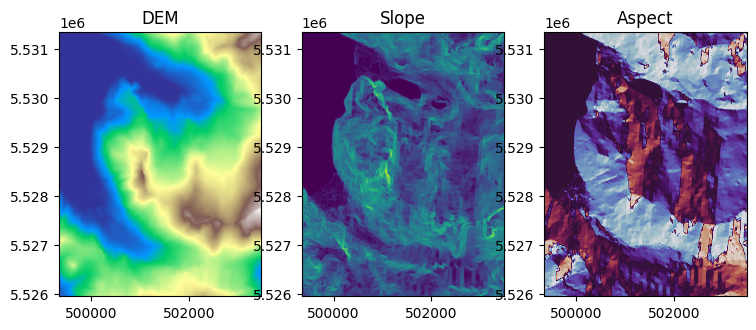

In [ ]:
#Creating Slope and Aspect and TPI Rasters from the DEM

slope_output_path = '/content/drive/MyDrive/PIXELS_python/Data/slope.tif'
aspect_output_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect.tif'

# Open the DEM raster
with rasterio.open(dem_path) as dem_src:
    # Read the DEM data as a numpy array
    dem = dem_src.read(1)

    # Calculate slope using numpy.gradient
    slope_x, slope_y = np.gradient(dem_src.read(1), dem_src.res[0], dem_src.res[1])
    slope = np.arctan(np.sqrt(slope_x**2 + slope_y**2))

    # Calculate aspect using numpy.arctan2
    aspect = np.arctan2(-slope_y, slope_x)

     # Save the slope as a new raster
    with rasterio.open(
        slope_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=slope.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as slope_dst:
        slope_dst.write(slope, 1)

     # Save the aspect as a new raster
    with rasterio.open(
        aspect_output_path,
        'w',
        driver='GTiff',
        width=dem_src.width,
        height=dem_src.height,
        count=1,
        dtype=aspect.dtype,
        crs=dem_src.crs,
        transform=dem_src.transform,
    ) as aspect_dst:
        aspect_dst.write(aspect, 1)

# Convert aspect values to degrees
aspect = np.degrees(aspect)

#calculating TPI
TPI_output_path = '/content/drive/MyDrive/PIXELS_python/Data/TPI.tif'
gdal_TPI_cmd = ['gdaldem', 'TPI', dem_path, TPI_output_path]

subprocess.run(gdal_TPI_cmd)

slope_path = slope_output_path
aspect_path = aspect_output_path
tpi_path = TPI_output_path

#Plotting the rasters
plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
plt.imshow(dem, cmap='terrain', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('DEM')

plt.subplot(1, 4, 2)
plt.imshow(slope, cmap='viridis', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Slope')

plt.subplot(1, 4, 3)
plt.imshow(aspect, cmap='twilight', extent=rasterio.plot.plotting_extent(dem_src))
plt.title('Aspect')

plt.show()



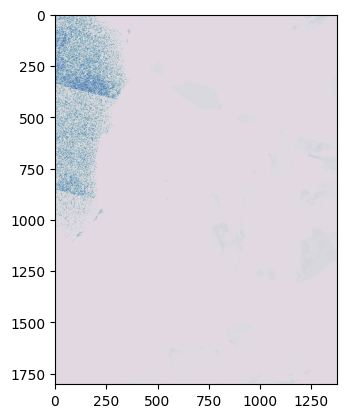

In [ ]:
#Creating NDVI
with rio.open(satellite2) as sat:
  NIR = sat.read(8)
  RED = sat.read(6)

#NDVI is (NIR-RED) / (NIR+RED)
  NIR_MINUS_RED = NIR - RED
  NIR_PLUS_RED = NIR + RED
  NDVI = NIR_MINUS_RED/NIR_PLUS_RED
  plt.imshow(NDVI, cmap="twilight")

# Normalizing Rasters

1001.9724190905449


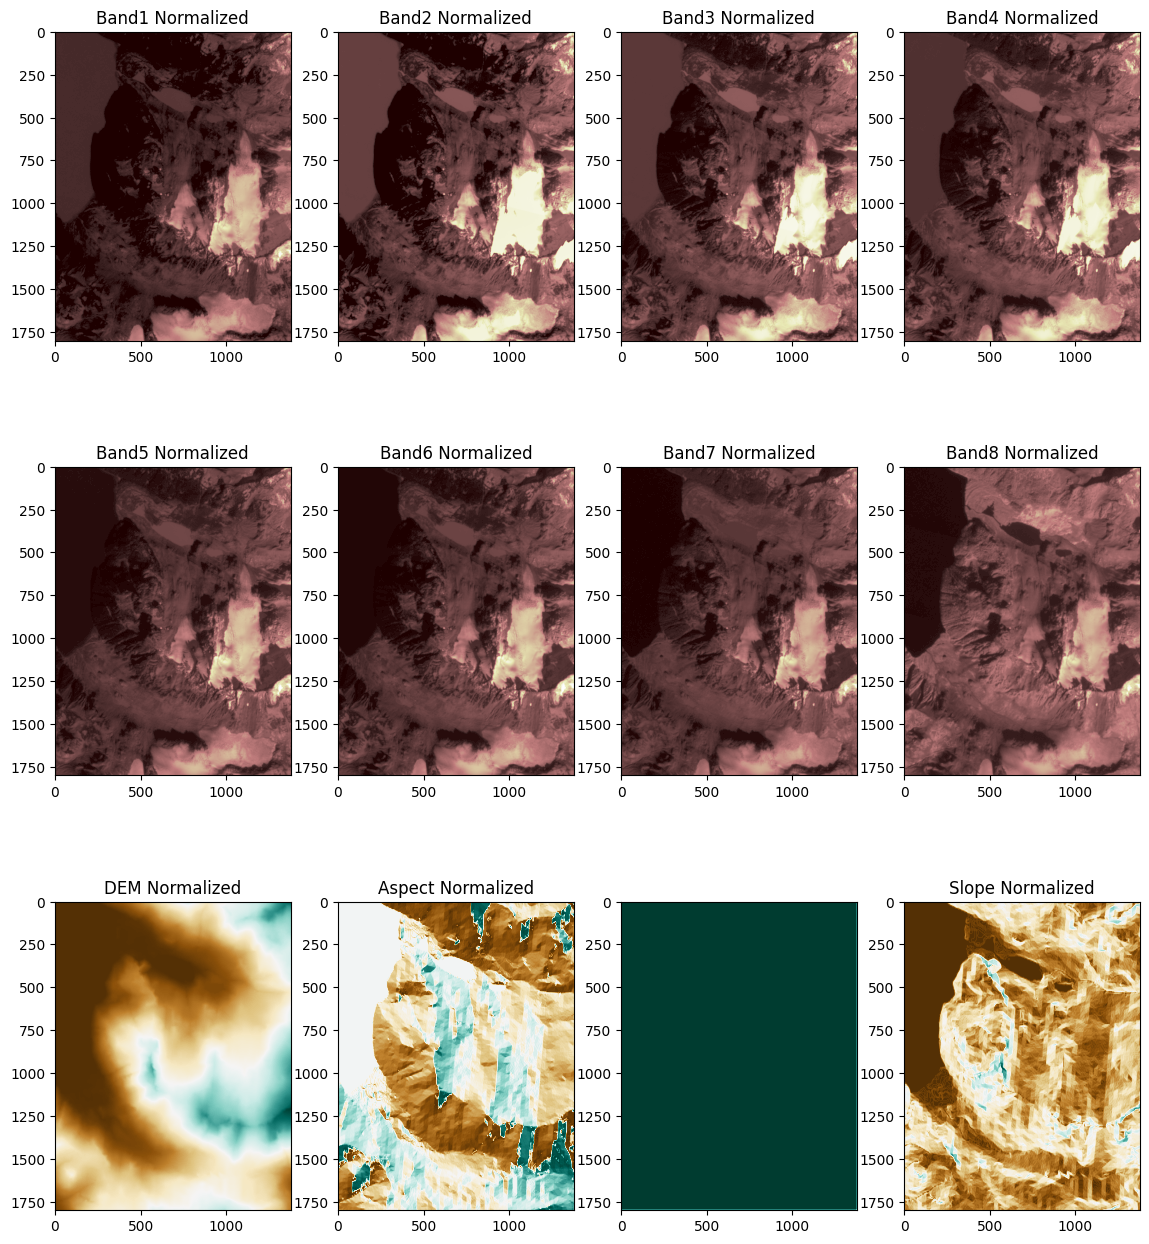

In [ ]:
#setting decimal precision of raster arrays
np.set_printoptions(precision=3)
np.get_printoptions()

#variables to change formatting of subplots
row_num = 3
colum_num = 4

#assigning each band to a variable and normalizing raster layer using standard normalization
with rio.open(satellite2) as sat:
  sat_transform = sat.transform
  sat_crs = sat.crs
  band1 = sat.read(1)
  band1_mean_pixel = np.mean(band1)
  band1_normalized = band1 / band1_mean_pixel
  print(band1_mean_pixel)

  band2 = sat.read(2)
  band2_mean_pixel = np.mean(band2)
  band2_minus_mean = band2 - band2_mean_pixel
  band2_std = np.std(band2)
  band2_normalized = band2_minus_mean / band2_std

  band3 = sat.read(3)
  band3_mean_pixel = np.mean(band3)
  band3_minus_mean = band3 - band3_mean_pixel
  band3_std = np.std(band3)
  band3_normalized = band3_minus_mean / band3_std

  band4 = sat.read(4)
  band4_mean_pixel = np.mean(band4)
  band4_minus_mean = band4 - band4_mean_pixel
  band4_std = np.std(band4)
  band4_normalized = band4_minus_mean / band4_std

  band5 = sat.read(5)
  band5_mean_pixel = np.mean(band5)
  band5_minus_mean = band5 - band5_mean_pixel
  band5_std = np.std(band5)
  band5_normalized = band5_minus_mean / band5_std

  band6 = sat.read(6)
  band6_mean_pixel = np.mean(band6)
  band6_minus_mean = band6 - band6_mean_pixel
  band6_std = np.std(band6)
  band6_normalized = band6_minus_mean / band6_std

  band7 = sat.read(7)
  band7_mean_pixel = np.mean(band7)
  band7_minus_mean = band7 - band7_mean_pixel
  band7_std = np.std(band7)
  band7_normalized = band7_minus_mean / band7_std

  band8 = sat.read(8)
  band8_mean_pixel = np.mean(band8)
  band8_minus_mean = band8 - band8_mean_pixel
  band8_std = np.std(band8)
  band8_normalized = band8_minus_mean / band8_std

  fig, ax = plt.subplots(row_num, colum_num, figsize=(14,16))
  plt.subplot(row_num, colum_num, 1)
  plt.imshow(band1_normalized, cmap='pink')
  plt.title('Band1 Normalized')
  plt.subplot(row_num, colum_num, 2)
  plt.imshow(band2_normalized, cmap='pink')
  plt.title('Band2 Normalized')
  plt.subplot(row_num, colum_num, 3)
  plt.imshow(band3_normalized, cmap='pink')
  plt.title('Band3 Normalized')
  plt.subplot(row_num, colum_num, 4)
  plt.imshow(band4_normalized, cmap='pink')
  plt.title('Band4 Normalized')
  plt.subplot(row_num, colum_num, 5)
  plt.imshow(band5_normalized, cmap='pink')
  plt.title('Band5 Normalized')
  plt.subplot(row_num, colum_num, 6)
  plt.imshow(band6_normalized, cmap='pink')
  plt.title('Band6 Normalized')
  plt.subplot(row_num, colum_num, 7)
  plt.imshow(band7_normalized, cmap='pink')
  plt.title('Band7 Normalized')
  plt.subplot(row_num, colum_num, 8)
  plt.imshow(band8_normalized, cmap='pink')
  plt.title('Band8 Normalized')

with rio.open(NDVI_path) as ndvi:
  NDVI = ndvi.read(1)
  ndvi_mean_pixel = np.mean(NDVI)
  ndvi_minus_mean = NDVI - ndvi_mean_pixel
  ndvi_std = np.std(NDVI)
  ndvi_normalized = ndvi_minus_mean / ndvi_std

with rio.open(dem_path) as dem:
  dem_transform = sat.transform
  dem_crs = sat.crs
  DEM = dem.read(1)
  dem_mean_pixel = np.mean(DEM)
  dem_minus_mean = DEM - dem_mean_pixel
  dem_std = np.std(DEM)
  dem_normalized = dem_minus_mean / dem_std
  plt.subplot(row_num, colum_num, 9)
  plt.imshow(DEM, cmap='BrBG')
  plt.title("DEM Normalized")

with rio.open(aspect_path) as asp:
  aspect = asp.read(1)
  aspect_mean_pixel = np.mean(aspect)
  aspect_minus_mean = aspect - aspect_mean_pixel
  aspect_std = np.std(aspect)
  aspect_normalized = aspect_minus_mean / aspect_std
  plt.subplot(row_num, colum_num, 10)
  plt.imshow(aspect, cmap='BrBG')
  plt.title("Aspect Normalized")

with rio.open(tpi_path) as tpi:
  TPI = tpi.read(1)
  tpi_mean_pixel = np.mean(TPI)
  tpi_minus_mean = TPI - tpi_mean_pixel
  tpi_std = np.std(TPI)
  tpi_normalized = tpi_minus_mean / tpi_std
  plt.subplot(row_num, colum_num, 11)
  plt.imshow(TPI, cmap='BrBG')

with rio.open(slope_path) as slp:
  slope = slp.read(1)
  slope_mean_pixel = np.mean(slope)
  slope_minus_mean = slope - slope_mean_pixel
  slope_std = np.std(slope)
  slope_normalized = slope_minus_mean / slope_std
  plt.subplot(row_num, colum_num, 12)
  plt.imshow(slope, cmap='BrBG')
  plt.title('Slope Normalized')



| 0.00, 0.00,-123.01|
| 0.00,-0.00, 49.93|
| 0.00, 0.00, 1.00| | 3.00, 0.00, 499350.00|
| 0.00,-3.00, 5531361.00|
| 0.00, 0.00, 1.00| | 3.00, 0.00, 499350.00|
| 0.00,-3.00, 5531361.00|
| 0.00, 0.00, 1.00|


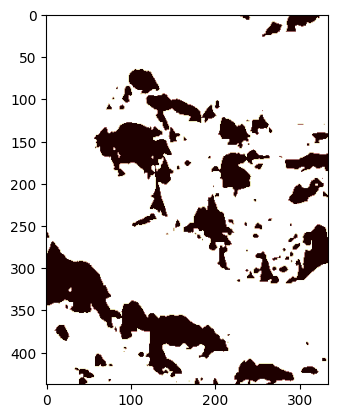

In [ ]:
with rio.open(shadow_path) as shd:
  shadows = shd.read(1)
  plt.imshow(shadows, cmap="pink")
  shadow_transform = shd.transform
  print(shadow_transform, dem_transform, sat_transform)

In [ ]:
#saving normalized rasters
aspect_norm_path = '/content/drive/MyDrive/PIXELS_python/Data/aspect_norm.tif'
dem_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/dem_norm.tif'
slope_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/slope_norm.tif'
tpi_norm_path = '/content/drive/MyDrive/PIXELS_python/Data/tpi_norm.tif'
band1_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band1_norm.tif'
band2_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band2_norm.tif'
band3_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band3_norm.tif'
band4_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band4_norm.tif'
band5_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band5_norm.tif'
band6_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band6_norm.tif'
band7_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band7_norm.tif'
band8_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/band8_norm.tif'
ndvi_norm_path =  '/content/drive/MyDrive/PIXELS_python/Data/ndvi_norm.tif'
shadow_norm_path = "/content/drive/MyDrive/PIXELS_python/Data/shadows_norm.tif"

sat_height, sat_width = band1.shape
#dem_height, dem_width = dem.shape

metadata_sat = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'width': sat_width,
    'height': sat_height,
    'crs': sat_crs,
    'transform': sat_transform
}

metadata_dem = {
    'driver': 'GTiff',
    'count': 1,
    'dtype': 'float32',
    'width': sat_width,
    'height': sat_height,
    'crs': dem_crs,
    'transform': dem_transform
}

def saving_sat(out_path, band):
  with rasterio.open(out_path, 'w', **metadata_sat) as rast:
    rast.write(band, 1)

def saving_topo(out_path, band):
  with rasterio.open(out_path, 'w', **metadata_dem) as rast:
    rast.write(band, 1)

saving_sat(band1_norm_path, band1_normalized)
saving_sat(band2_norm_path, band2_normalized)
saving_sat(band3_norm_path, band3_normalized)
saving_sat(band4_norm_path, band4_normalized)
saving_sat(band5_norm_path, band5_normalized)
saving_sat(band6_norm_path, band6_normalized)
saving_sat(band7_norm_path, band7_normalized)
saving_sat(band8_norm_path, band8_normalized)
saving_sat(ndvi_norm_path, ndvi_normalized)
saving_topo(dem_norm_path, dem_normalized)
saving_topo(tpi_norm_path, tpi_normalized)
saving_topo(aspect_norm_path, aspect_normalized)
saving_topo(slope_norm_path, slope_normalized)
saving_topo(shadow_norm_path, shadows)

In [ ]:
#stacking rasters
input_rasters = [band1_norm_path, band2_norm_path, band3_norm_path, band4_norm_path, band5_norm_path, band6_norm_path,
                 band7_norm_path, band8_norm_path, dem_norm_path, slope_norm_path, aspect_norm_path, tpi_norm_path, ndvi_norm_path]

output_stack = "/content/drive/MyDrive/PIXELS_python/Data/virtual_raster_normalized.tif"
gdal_cmd_vrt = ['gdalbuildvrt', '-separate', '-resolution', 'highest', '-r', 'near', output_stack,] + input_rasters

subprocess.run(gdal_cmd_vrt)

stacked = output_stack

#saving each stacked band as a variable to inspect data
with rio.open(stacked) as stk:
  stk1 = stk.read(1)
  stk2 = stk.read(2)
  stk3 = stk.read(3)
  stk4 = stk.read(4)
  stk5 = stk.read(5)
  stk6 = stk.read(6)
  stk7 = stk.read(7)
  stk8 = stk.read(8)
  stk_dem = stk.read(9)
  stk_slope = stk.read(10)
  stk_aspect = stk.read(11)
  stk_tpi = stk.read(12)
  stk_ndvi = stk.read(13)
  num_bands = stk.count

[[-0.563 -0.261 -0.153 ... -0.785 -0.883 -0.991]
 [-0.789 -0.45  -0.579 ... -0.789 -0.835 -0.921]
 [-0.297 -0.524 -0.657 ... -0.878 -0.845 -0.839]
 ...
 [ 0.225  0.206  0.232 ... -0.463 -0.442 -0.457]
 [ 0.212  0.264  0.356 ... -0.417 -0.364 -0.341]
 [ 0.135  0.208  0.263 ... -0.399 -0.411 -0.33 ]]


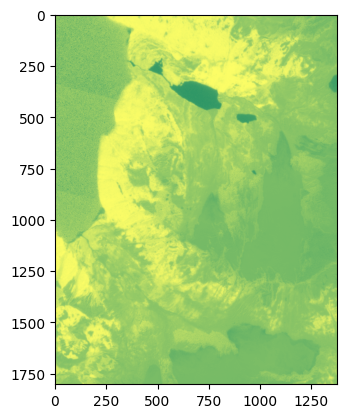

In [ ]:
#visualize layers in the stack
plt.imshow(stk_ndvi, cmap="summer")
print(stk_ndvi)

#Training The Model

In [ ]:
stacked = "/content/drive/MyDrive/PIXELS_python/Data/virtual_raster_normalized.tif" #this it the output of my stacked raster so that I don't have to run the normalizing rasters section everytime I want to run the model,
                                                                                    #delete if you are another user using this model, or change to your output stacked raster to automate your own script :)

import time
import collections

landclass_array = collections.deque([])
stacked_deque_array = collections.deque([])

with rio.open(stacked) as stack_src:
  with fiona.open(split_train) as shp:
      print('Number of coords:', len(shp))
      for index,feature in enumerate(shp):
          siteID = feature['properties']['subnumclas']
          coords = feature['geometry']['coordinates']
          value = [v for v in stack_src.sample([coords])]
          landclass_array.append(np.array([siteID]))
          stacked_deque_array.append(np.array(np.squeeze(value)))

landclass_np_array = np.asarray(landclass_array)
stacked_np_array = np.asarray(stacked_deque_array)

#comment out later
split_train_np = landclass_np_array
train_stacked_np = stacked_np_array

Number of coords: 9287


In [ ]:
import time
import collections

landclass_array2 = collections.deque([])
stacked_deque_array2 = collections.deque([])

with rio.open(stacked) as stack_src:
  with fiona.open(split_test) as shp:
      print('Number of coords:', len(shp))
      for index,feature in enumerate(shp):
          siteID = feature['properties']['subnumclas']
          coords = feature['geometry']['coordinates']
          value = [v for v in stack_src.sample([coords])]
          landclass_array2.append(np.array([siteID]))
          stacked_deque_array2.append(np.array(np.squeeze(value)))

         # if index%1000 == 0:
          #  print('Index:', index)

landclass_np_array_new = np.asarray(landclass_array2)
stacked_np_array_new = np.asarray(stacked_deque_array2)

#comment out later
split_test_np = landclass_np_array_new
test_stacked_np = stacked_np_array_new

Number of coords: 8907


In [ ]:
X_train = train_stacked_np
y_train = split_train_np

X_test = test_stacked_np
y_test = split_test_np

y_train_inner = [inner_array[0] for inner_array in y_train]

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (9287, 13)
X_test Shape: (8907, 13)
y_train Shape: (9287, 1)
y_test Shape:(8907, 1)


# **Using PyCaret to test dif models**

In [ ]:
#converting numpy array into pandas array for compatibility with pycaret

X_1 = [inner_array[0] for inner_array in X]
X_2 = [inner_array[1] for inner_array in X]
X_3 = [inner_array[2] for inner_array in X]
X_4 = [inner_array[3] for inner_array in X]
X_5 = [inner_array[4] for inner_array in X]
X_6 = [inner_array[5] for inner_array in X]
X_7 = [inner_array[6] for inner_array in X]
X_8 = [inner_array[7] for inner_array in X]
X_9 = [inner_array[8] for inner_array in X]
X_10 = [inner_array[9] for inner_array in X]
X_11 = [inner_array[10] for inner_array in X]
X_12 = [inner_array[11] for inner_array in X]

#dataset = pd.DataFrame({'classes': Yi, 'raster': list(Xi)}, columns=['raster val', 'label'])
df = pd.DataFrame({'Class': Y, 'Band1': X_1, 'Band2': X_2, 'Band3': X_3, 'Band4': X_4, 'Band5': X_5, 'Band6': X_6, 'Band7': X_7, 'Band8': X_8, 'DEM': X_9, 'Slope': X_10, 'Aspect': X_11, 'TPI': X_12})

# Displaying the DataFrame
print(df)

       Class     Band1     Band2     Band3     Band4     Band5     Band6  \
0          1  0.153697 -0.572849 -0.488321 -0.427564 -0.370096 -0.367049   
1          1  0.128746 -0.564817 -0.480029 -0.422105 -0.358585 -0.369739   
2          1  0.091819 -0.576499 -0.509744 -0.459634 -0.403989 -0.430936   
3          1  0.165673 -0.524660 -0.446168 -0.422105 -0.359864 -0.389242   
4          1  0.085831 -0.591832 -0.511126 -0.444622 -0.409105 -0.406726   
...      ...       ...       ...       ...       ...       ...       ...   
33004      6  0.012974 -0.741511 -0.671447 -0.613845 -0.617582 -0.665636   
33005      6  0.009980 -0.740781 -0.663154 -0.641139 -0.645080 -0.673706   
33006      6  0.009980 -0.737130 -0.661772 -0.611798 -0.597118 -0.632011   
33007      6  0.017965 -0.712305 -0.580230 -0.508763 -0.486484 -0.551312   
33008      6  0.014970 -0.741511 -0.677666 -0.615210 -0.636127 -0.662273   

          Band7     Band8       DEM     Slope    Aspect       TPI  
0     -0.223484  0.

In [ ]:
## has ongoing problem with data visualisation

from pycaret.classification import *
exp_name = setup(data = df,  target = 'Class')
rf = create_model('rf')
pred_holdout = predict_model(rf)
pred_unseen = predict_model(rf, data = df)

ModuleNotFoundError: No module named 'pycaret'

In [ ]:
best = compare_models()
#32 mins, 1934sec, last recorded time to run

# Fitting the model

In [ ]:
#GRID SEARCH FOR RANDOM FOREST

from sklearn.model_selection import GridSearchCV
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

model = RandomForestClassifier()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train_inner) #used y_train inner for new training split to unnest 2D array

# Access results
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the test set
test_accuracy = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)


Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 50}
Test Accuracy: 0.6474866037254402


In [ ]:
#GRID SEARCH FOR SVC
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix


# Define the hyperparameter grid
param_grid = {
    'kernel': ["rbf", "poly", "linear"],
    'gamma': ['scale', 'auto', 10],
    'max_iter': [2, 5, 10],
}

model = SVC()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train_inner)

# Access results
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate on the test set
test_accuracy = best_model.score(X_test, y_test)

print("Best Hyperparameters:", best_params)
print("Test Accuracy:", test_accuracy)

#Best Hyperparameters: {'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 5}
#Test Accuracy: 0.820627802690583

#Best Hyperparameters: {'gamma': 'auto', 'kernel': 'rbf', 'max_iter': 5}
#Test Accuracy: 0.7092279579716766

Best Hyperparameters: {'gamma': 10, 'kernel': 'poly', 'max_iter': 5}
Test Accuracy: 0.6491451900995152


In [ ]:
#RF classifier
clf = RandomForestClassifier(n_estimators = 50, min_samples_leaf = 4, min_samples_split = 10, max_depth = 20)     #random forest
#clf = SVC(kernel='rbf', gamma = 'auto', max_iter = 5)                                                               #SVC model
clf.fit(X_train, y_train_inner)

y_pred = clf.predict(X_test)

# metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))



ACCURACY OF THE MODEL:  0.7093297406534187


In [ ]:
### K MEANSSSS
from sklearn.cluster import KMeans
import numpy as np

X = np.column_stack([stk1.flatten(), stk2.flatten(), stk3.flatten(), stk4.flatten(), stk5.flatten(), stk6.flatten(), stk7.flatten(), stk8.flatten(), stk_dem.flatten(),
                     stk_slope.flatten(), stk_aspect.flatten(), stk_ndvi.flatten()]) #stk_tpi.flatten(),


cName = 'top_down'
exp_name = f'/content/drive/MyDrive/PIXELS_python/Data/model_exports/{cName}.tif'

#X = all_stacks
km = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#y_km = km.fit_predict(X)


km.fit(X)
cluster_labels = km.predict(X)


cluster_labels = km.labels_.reshape(band1.shape) #change

# Create a new GeoTIFF file for the clustered result
output_file = 'clustered_result.tif'
with rasterio.open(
        exp_name,
        'w',
        driver='GTiff',
        height=cluster_labels.shape[0],
        width=cluster_labels.shape[1],
        count=1,
        dtype=cluster_labels.dtype,
        crs=sat.crs,
        transform=sat.transform,
) as dst:
    dst.write(cluster_labels, 1)

NameError: name 'stk1' is not defined

Kappa coefficient: 0.6751701216647982
Confusion Matrix RF bottom-up: 
 [[1131    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0    0    0]
 [   0    0  914    0    0    0    0    0    0    0    0    0]
 [   0    0    0  861    0    0    0    0    0    0    0    0]
 [   1    0    0    0  955   44    0    0    0    0    0    0]
 [   0    0    0    0    0  882    0    2    0    1    0    1]
 [   0    7    0    0    0    0  348   11    0   57   26    9]
 [   0    3    0    0    0   16   10    0    0   59  115   15]
 [   0  193    0    0    0    0    1    3    0    0  125   54]
 [   0    0    0    0    0    0    3   79    0   17    0    1]
 [   1  495    0    0    0    2    0    0    0    0  210  290]
 [   0  179    0    0    0    0    0    0    0    0  786    0]]


<ipython-input-16-60c9285a6a5c>:24: RuntimeWarning: invalid value encountered in divide
  producers_accuracy = np.diag(cm) / np.sum(cm, axis=0)


Users' Accuracy:
Shadow: 1.00
Water: 1.00
Water till: 1.00
Glacier/Snow: 1.00
Conifer: 0.95
Alnus: 1.00
Equisetum: 0.76
Salix: 0.00
Community 1.1: 0.00
Community 1.2: 0.17
Community 2.1: 0.21
Community 2.2: 0.00

Producers' Accuracy:
Shadow: 1.00
Water: 0.53
Water till: 1.00
Glacier/Snow: 1.00
Conifer: 1.00
Alnus: 0.93
Equisetum: 0.96
Salix: 0.00
Community 1.1: nan
Community 1.2: 0.13
Community 2.1: 0.17
Community 2.2: 0.00
Overall Accuracy: 0.71


<Figure size 640x480 with 0 Axes>

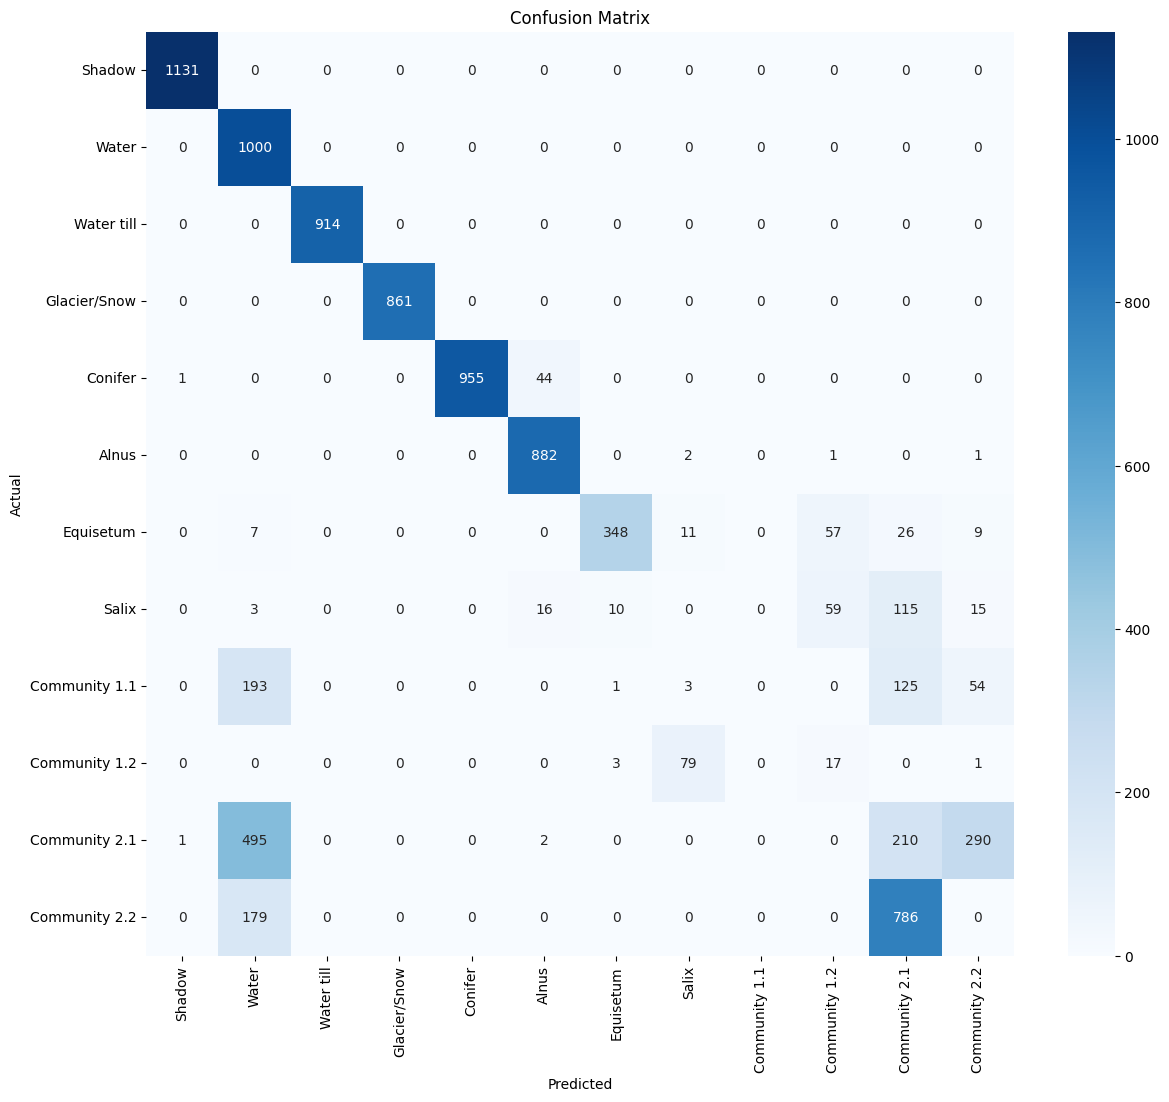

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score


# Calculate Kappa coefficient
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa coefficient:", kappa)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix RF bottom-up: \n', cm)
np.savetxt('/content/drive/MyDrive/PIXELS_python/Data/model_exports/confusion_matrix.csv', cm, delimiter=',', fmt='%d')


#label_name = ["Shadow", "Water", "Water till", "Glacier/Snow", "Conifer",  "Alnus", "Equisetum", "Salix", "Mixed 10-25%", "Mixed 25-50%", "Mixed 50-100%"] # top-down
label_name = ["Shadow", "Water", "Water till", "Glacier/Snow", "Conifer",  "Alnus", "Equisetum", "Salix", "Community 1.1", "Community 1.2", "Community 2.1", "Community 2.2"] # bottom_up


# Calculate users' and producers' accuracies
users_accuracy = np.diag(cm) / np.sum(cm, axis=1)
producers_accuracy = np.diag(cm) / np.sum(cm, axis=0)

plt.tight_layout()

# Set figure size
plt.figure(figsize=(14, 12))

# Plot the confusion matrix with percent accuracies
sns.heatmap(cm, annot=True, cmap="Blues", fmt='.0f', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

# Print users' accuracy
print("Users' Accuracy:")
for i, acc in enumerate(users_accuracy):
    print(f"{label_name[i]}: {acc:.2f}")

# Print producers' accuracy
print("\nProducers' Accuracy:")
for i, acc in enumerate(producers_accuracy):
    print(f"{label_name[i]}: {acc:.2f}")

# Calculate overall accuracy
overall_accuracy = np.diag(cm).sum() / cm.sum()

# Print overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Save the figure
confusion_matrix_name = 'bottom_up_cm_rawvalues'
exp_cm = f'/content/drive/MyDrive/PIXELS_python/Data/model_exports/{confusion_matrix_name}.tif'
plt.savefig(exp_cm, dpi=300)  # Change file format and resolution as needed

plt.show()

Kappa coefficient: 0.6877824480771358
Confusion Matrix RF: 
 [[1131    0    0    0    0    0    0    0    0    0    0    0]
 [   0 1000    0    0    0    0    0    0    0    0    0    0]
 [   0    0  914    0    0    0    0    0    0    0    0    0]
 [   0    0    0  861    0    0    0    0    0    0    0    0]
 [   0    0    0    0  951   49    0    0    0    0    0    0]
 [   0    0    0    0    0  883    0    3    0    0    0    0]
 [   0    7    0    0    0    0  343    3    0   58   33   14]
 [   0    3    0    0    0    6   16    0    0  111   68   14]
 [   0  215    0    0    0    0    4    4    0    0  101   52]
 [   0    0    0    0    0    0    4   90    0    6    0    0]
 [   1  366    0    0    0    1    0    0    0    0  328  302]
 [   0  240    0    0    0    0    0    0    0    0  725    0]]


<ipython-input-99-daf757670b21>:18: RuntimeWarning: divide by zero encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] #axis = 1 for users accuracy, axis = 0 for producers
<ipython-input-99-daf757670b21>:18: RuntimeWarning: invalid value encountered in divide
  cm_percent = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] #axis = 1 for users accuracy, axis = 0 for producers


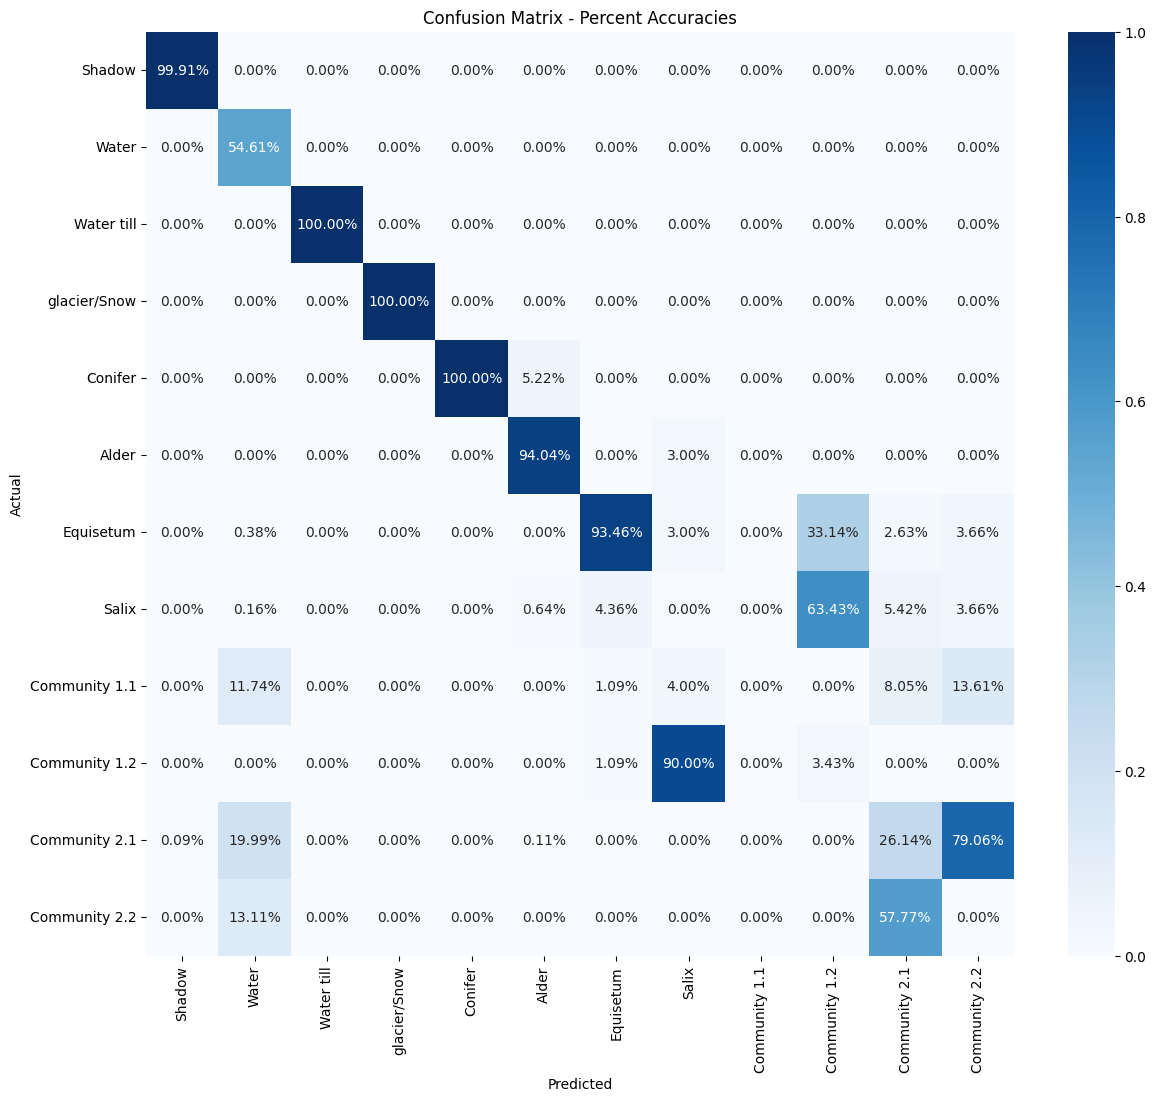

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

# Calculate Kappa coefficient
kappa = cohen_kappa_score(y_test, y_pred)
print("Kappa coefficient:", kappa)

cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix RF: \n', cm)

#label_name = ["Shadow", "Water", "Water till", "Glacier/Snow", "Conifer",  "Alnus", "Equisetum", "Salix", "Mixed 10-25%", "Mixed 25-50%", "Mixed 50-100%"] # top-down
label_name = ["Shadow", "Water", "Water till", "Glacier/Snow", "Conifer",  "Alnus", "Equisetum", "Salix", "Community 1.1", "Community 1.2", "Community 2.1", "Community 2.2"] # bottom_up

labels = np.unique(y_train)

# Calculate percent accuracies
cm_percent = cm.astype('float') / cm.sum(axis=0)[:, np.newaxis] #axis = 1 for users accuracy, axis = 0 for producers

# Calculate percent accuracies
cm_percent = np.zeros_like(cm, dtype=float)
for i in range(cm.shape[0]):
    if np.sum(cm[:, i]) != 0:  # Check if the sum along the column is not zero
        cm_percent[:, i] = cm[:, i] / np.sum(cm[:, i])  # Calculate percentage accuracies


# Set figure size
plt.figure(figsize=(14, 12))  # Adjust dimensions as needed

# Plot the confusion matrix with percent accuracies
sns.heatmap(cm_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Percent Accuracies')

# Save the figure
confusion_matrix_name = 'bottom_up_cm_producers'
exp_cm = f'/content/drive/MyDrive/PIXELS_python/Data/model_exports/{confusion_matrix_name}.tif'
plt.savefig(exp_cm, dpi=300)  # Change file format and resolution as needed

plt.show()



# Exporting the model as a raster

In [ ]:
#drone
cName = 'just_sat'
exp_name = f'/content/drive/MyDrive/PIXELS_python/Data/model_exports/{cName}.tif'

num_bands = 13
img = rio.open(stacked)
img_arr = img.read()
bands = img_arr.shape[0]
print(f'Height: {img_arr.shape[1]}\nWidth: {img_arr.shape[2]}\nBands: {img_arr.shape[0]}\n')
img_n = np.moveaxis(img_arr, 0, -1)
img_n = img_n.reshape(-1, num_bands)
print('reshaped full data shape  for prediction: ',img_n.shape)
metadata = img.meta
height = metadata.get('height')
width = metadata.get('width')
crs = metadata.get('crs')
transform = metadata.get('transform')

Height: 1802
Width: 1377
Bands: 8

reshaped full data shape  for prediction:  (2481354, 8)


In [ ]:
pred_full = clf.predict(img_n)

print('Prediction Done, now exporting raster \n')

img_reshape = pred_full.reshape(height, width)


out_raster = rio.open(exp_name,
                                         'w',
                                          driver='GTiff',
                                          height=height,
                                          width=width,
                                          count=1, # output band number
                                          dtype='uint16', #output data type
                                          crs=crs,
                                          transform = transform,
                                          nodata = 255 #nodata
                                          )

out_raster.write(img_reshape, 1)
out_raster.close()

Prediction Done, now exporting raster 



In [ ]:
from csv import reader, writer
with open('/content/drive/MyDrive/PIXELS_python/Garibaldi_plant_data_Genus_spp.csv') as f, open('/content/drive/MyDrive/PIXELS_python/Garibaldi_plant_data_transposed.csv', 'w') as fw:
    writer(fw, delimiter=',').writerows(zip(*reader(f, delimiter=',')))

In [ ]:
import csv

with open('/content/drive/MyDrive/PIXELS_python/Garibaldi_plant_data_transposed.csv', 'r') as f:
    reader = csv.reader(f)
    data = list(reader)




data = np.array(data)

#selecting certain rows
dendro_array = data[2:42]
mod_data = dendro_array[:, 1:]



# Replace empty strings with 0
mod_data[mod_data == ''] = 0

# Convert the array to object dtype
mod_data = mod_data.astype(object)

# Convert the array to float
dendro_data = mod_data.astype(float)

print(dendro_data)

[[0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.08  0.    ... 0.    0.    0.   ]
 [0.    0.013 0.006 ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.    0.    0.   ]
 [0.    0.035 0.    ... 0.    5.5   0.   ]
 [0.    0.5   0.5   ... 0.    0.5   0.   ]]


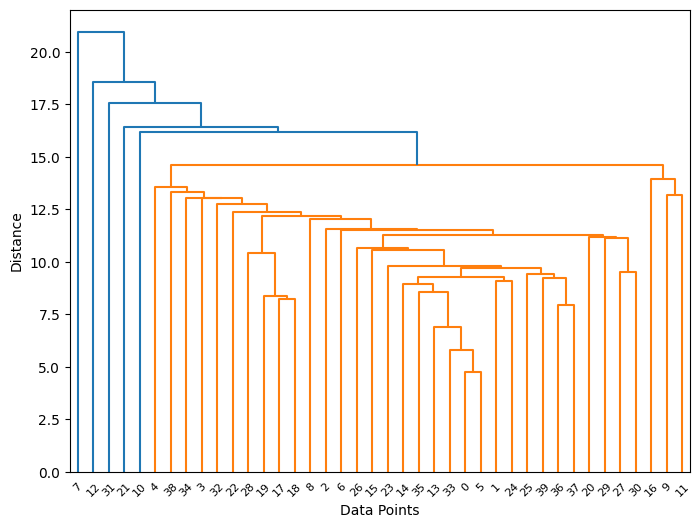

In [ ]:
from scipy.cluster import hierarchy


# Calculate the hierarchical clustering
linkage_matrix = hierarchy.linkage(dendro_data, "single")

# Plot the dendrogram
plt.figure(figsize=(8, 6))
dn = hierarchy.dendrogram(linkage_matrix)

# Add labels
plt.xlabel("Data Points")
plt.ylabel("Distance")

plt.show()


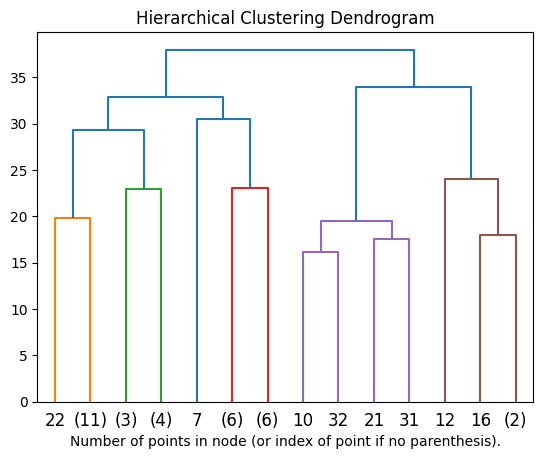

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = dendro_data

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

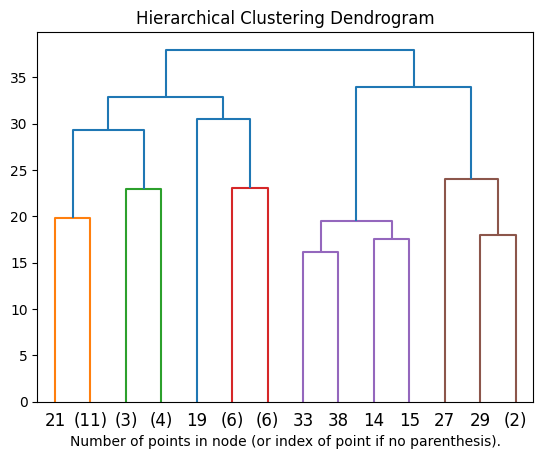

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import matplotlib.pyplot as plt

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

X = dendro_data

# Setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X)
plt.title("Hierarchical Clustering Dendrogram")
# Plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode="level", p=3, labels=model.labels_)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def extract_cluster_data(model):
    # Initialize an empty dictionary to store cluster data
    cluster_data = {}

    # Loop through each cluster level
    for i, merge in enumerate(model.children_):
        # Initialize an empty list to store labels for each cluster at this level
        labels = []

        # Loop through each child index in the merge
        for child_idx in merge:
            # If the child index is less than the number of samples, it's a leaf node
            if child_idx < len(model.labels_):
                # Append the label of the leaf node to the list
                labels.append(model.labels_[child_idx])
            # If the child index is greater than or equal to the number of samples,
            # it's an internal node representing a cluster
            else:
                # Append the labels of the children of this internal node to the list
                labels.extend(cluster_data[child_idx - len(model.labels_)])

        # Add the list of labels for this cluster level to the dictionary
        cluster_data[i] = labels

    return cluster_data

# Example data (replace this with your data)
#X = np.random.rand(10, 2)

# Setting distance_threshold=0 ensures we compute the full tree.
#model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
#model = model.fit(X)

# Extract cluster data
cluster_data = extract_cluster_data(model)

# Convert cluster data to DataFrame
cluster_df = pd.DataFrame(cluster_data.items(), columns=['Cluster Level', 'Cluster Labels'])

# Save cluster data to CSV file
cluster_df.to_csv('/content/drive/MyDrive/PIXELS_python/dendrogram_info.csv', index=False)
